In [2]:
!pip install statsmodels



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: C:\Users\jvand\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.fft import fft
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [4]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

display(train_data.head(5))
display(test_data.head(5))

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1


,date_hour,holiday,weathersit,temp,atemp,hum,windspeed
0,2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000
1,2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000
2,2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000
3,2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343
4,2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896


## Exploratieve Data Analyse

In [5]:
display(train_data.dtypes)
display(train_data.describe())

date_hour      object
holiday         int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


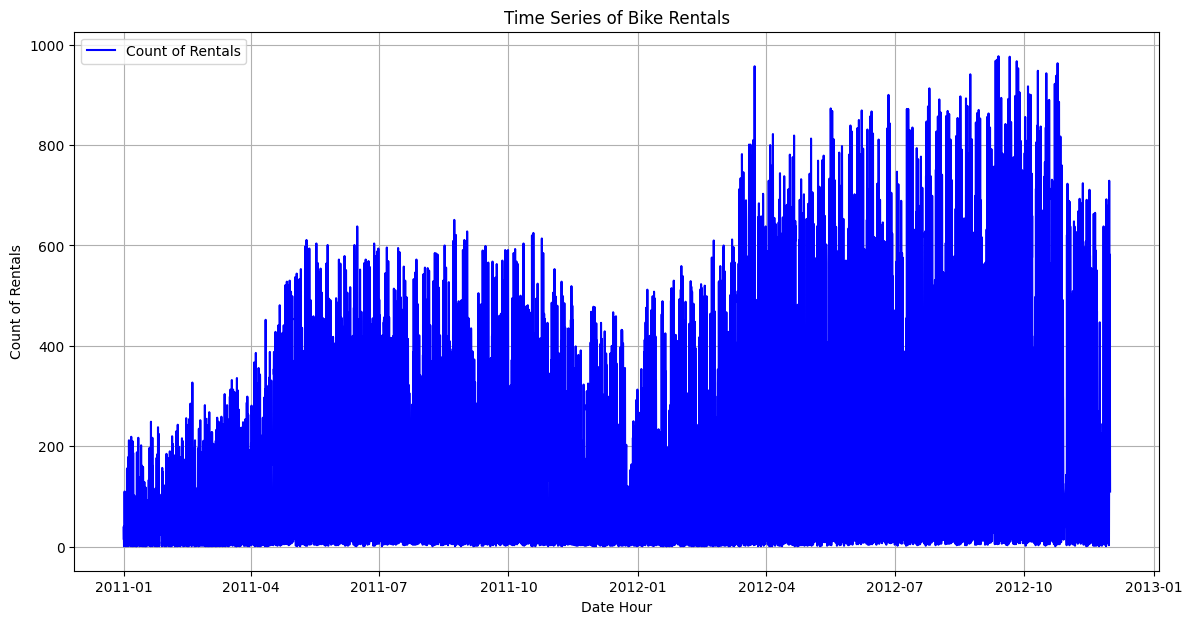

In [6]:
train_data['date_hour'] = pd.to_datetime(train_data['date_hour'])

train_data.set_index('date_hour', inplace=True)

plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['cnt'], color='blue', label='Count of Rentals')
plt.title('Time Series of Bike Rentals')
plt.xlabel('Date Hour')
plt.ylabel('Count of Rentals')
plt.legend()
plt.grid()
plt.show()


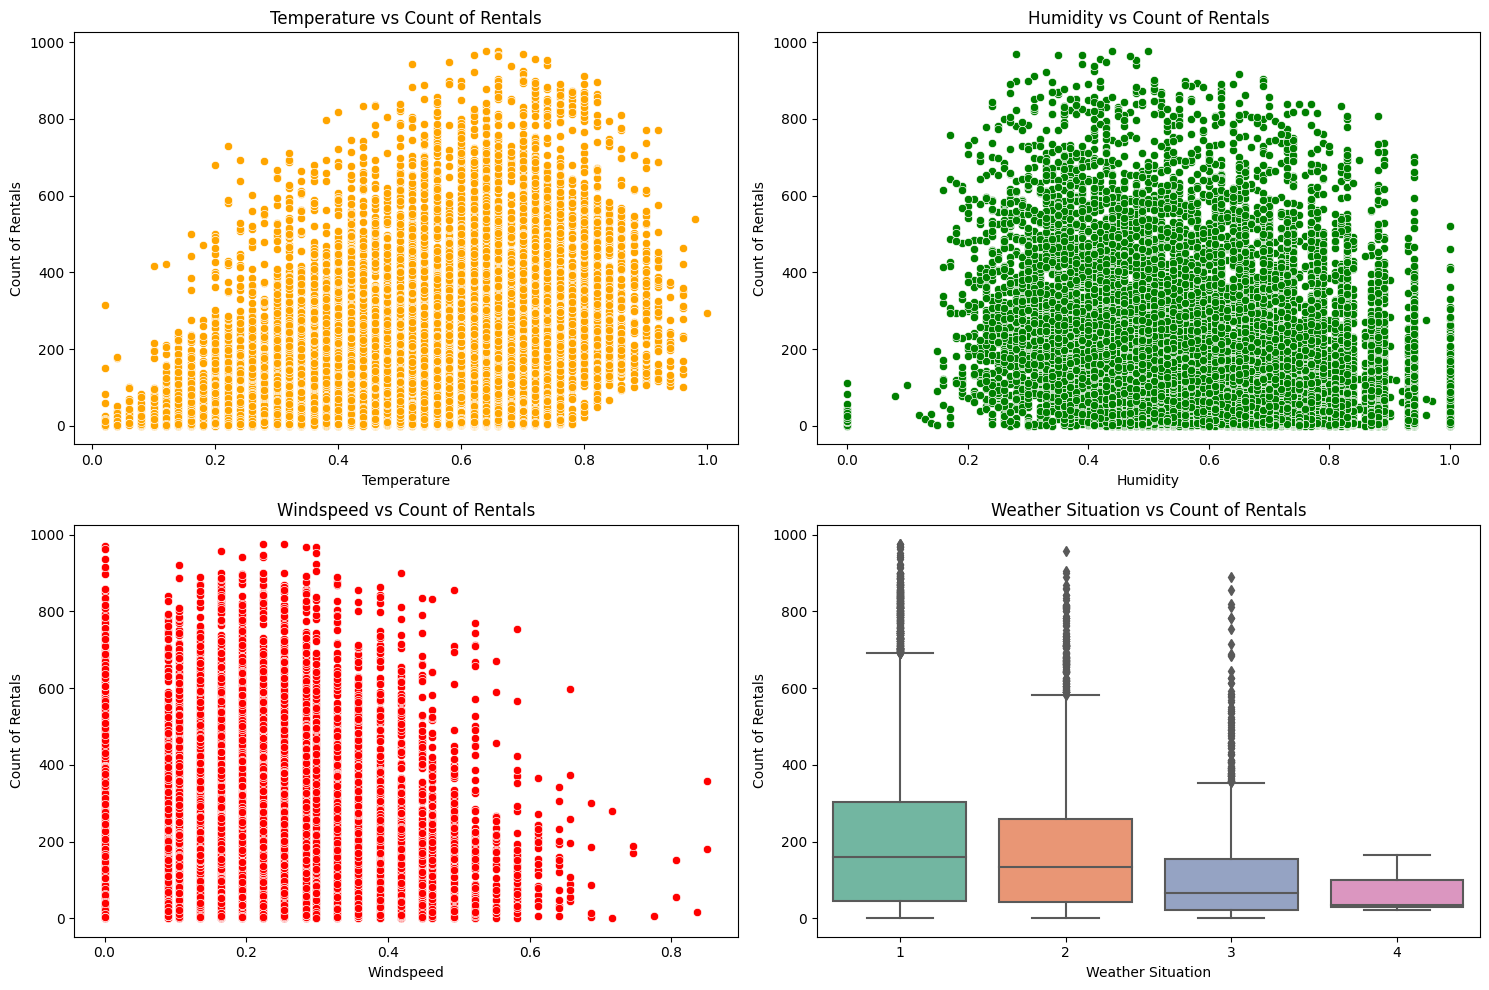

In [7]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.scatterplot(data=train_data, x='temp', y='cnt', color='orange')
plt.title('Temperature vs Count of Rentals')
plt.xlabel('Temperature')
plt.ylabel('Count of Rentals')

plt.subplot(2, 2, 2)
sns.scatterplot(data=train_data, x='hum', y='cnt', color='green')
plt.title('Humidity vs Count of Rentals')
plt.xlabel('Humidity')
plt.ylabel('Count of Rentals')

plt.subplot(2, 2, 3)
sns.scatterplot(data=train_data, x='windspeed', y='cnt', color='red')
plt.title('Windspeed vs Count of Rentals')
plt.xlabel('Windspeed')
plt.ylabel('Count of Rentals')

plt.subplot(2, 2, 4)
sns.boxplot(data=train_data, x='weathersit', y='cnt', palette='Set2')
plt.title('Weather Situation vs Count of Rentals')
plt.xlabel('Weather Situation')
plt.ylabel('Count of Rentals')

plt.tight_layout()
plt.show()

1. De tijdrijgrafiek laat zien dat verhuur duidelijke seizoenspatronen heeft, met pieken tijdens bepaalde periodes van het jaar.  
2. Er is een positieve correlatie tussen temperatuur en het aantal verhuur, wat suggereert dat hogere temperaturen leiden tot meer verhuur.  
3. Luchtvochtigheid lijkt een negatief effect te hebben op verhuur; naarmate de luchtvochtigheid toeneemt, neemt het aantal verhuurd af.  
4. Windsnelheid toont een zwakke negatieve correlatie met verhuur, wat erop wijst dat hogere windsnelheden gebruikers kunnen ontmoedigen om te huren.  
5. De boxplot voor weersituatie laat zien dat bepaalde weersomstandigheden (zoals helder of licht bewolkt) geassocieerd zijn met hogere aantallen verhuur in vergelijking met andere omstandigheden (zoals regen of sneeuw).  


### Data cleaning

In [8]:
missing_values = train_data.isnull().sum()
duplicates = train_data.duplicated().sum()

print('Missing Values per Column:')
print(missing_values)
print(f'Total Duplicates: {duplicates}')

Missing Values per Column:
holiday       0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64
Total Duplicates: 106


In [9]:
train_data_cleaned = train_data.drop_duplicates()
cleaned_shape = train_data_cleaned.shape

print(f'Original shape: {train_data.shape}')
print(f'Cleaned shape: {cleaned_shape}')

Original shape: (16637, 7)
Cleaned shape: (16531, 7)


### Relevantie bepalen

In [10]:
correlation_matrix = train_data_cleaned.corr()
correlation_matrix

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
holiday,1.000000,-0.019890,-0.026821,-0.030590,-0.012500,0.004342,-0.027276
weathersit,-0.019890,1.000000,-0.094848,-0.098067,0.413065,0.029597,-0.141626
temp,-0.026821,-0.094848,1.000000,0.987445,-0.063364,-0.028047,0.408919
atemp,-0.030590,-0.098067,0.987445,1.000000,-0.046640,-0.064435,0.404527
hum,-0.012500,0.413065,-0.063364,-0.046640,1.000000,-0.282971,-0.325283
windspeed,0.004342,0.029597,-0.028047,-0.064435,-0.282971,1.000000,0.094203
cnt,-0.027276,-0.141626,0.408919,0.404527,-0.325283,0.094203,1.000000


In [11]:
relevant_features = ['temp', 'atemp', 'hum', 'windspeed', 'weathersit', 'cnt']
train_data_final = train_data_cleaned[relevant_features]

train_data_final.head()

,temp,atemp,hum,windspeed,weathersit,cnt
date_hour,,,,,,
2011-01-01 00:00:00,0.24,0.2879,0.81,0.0,1,16
2011-01-01 01:00:00,0.22,0.2727,0.80,0.0,1,40
2011-01-01 02:00:00,0.22,0.2727,0.80,0.0,1,32
2011-01-01 03:00:00,0.24,0.2879,0.75,0.0,1,13
2011-01-01 04:00:00,0.24,0.2879,0.75,0.0,1,1


## Time series feature engineering

In [12]:
train_data_final['year'] = train_data_final.index.year
train_data_final['month'] = train_data_final.index.month
train_data_final['day'] = train_data_final.index.day
train_data_final['day_of_week'] = train_data_final.index.dayofweek
train_data_final['quarter'] = train_data_final.index.quarter

train_data_final['sin_month'] = np.sin(2 * np.pi * train_data_final['month'] / 12)
train_data_final['cos_month'] = np.cos(2 * np.pi * train_data_final['month'] / 12)

train_data_final.head()

,temp,atemp,hum,windspeed,weathersit,cnt,year,month,day,day_of_week,quarter,sin_month,cos_month
date_hour,,,,,,,,,,,,,
2011-01-01 00:00:00,0.24,0.2879,0.81,0.0,1,16,2011,1,1,5,1,0.5,0.866025
2011-01-01 01:00:00,0.22,0.2727,0.80,0.0,1,40,2011,1,1,5,1,0.5,0.866025
2011-01-01 02:00:00,0.22,0.2727,0.80,0.0,1,32,2011,1,1,5,1,0.5,0.866025
2011-01-01 03:00:00,0.24,0.2879,0.75,0.0,1,13,2011,1,1,5,1,0.5,0.866025
2011-01-01 04:00:00,0.24,0.2879,0.75,0.0,1,1,2011,1,1,5,1,0.5,0.866025


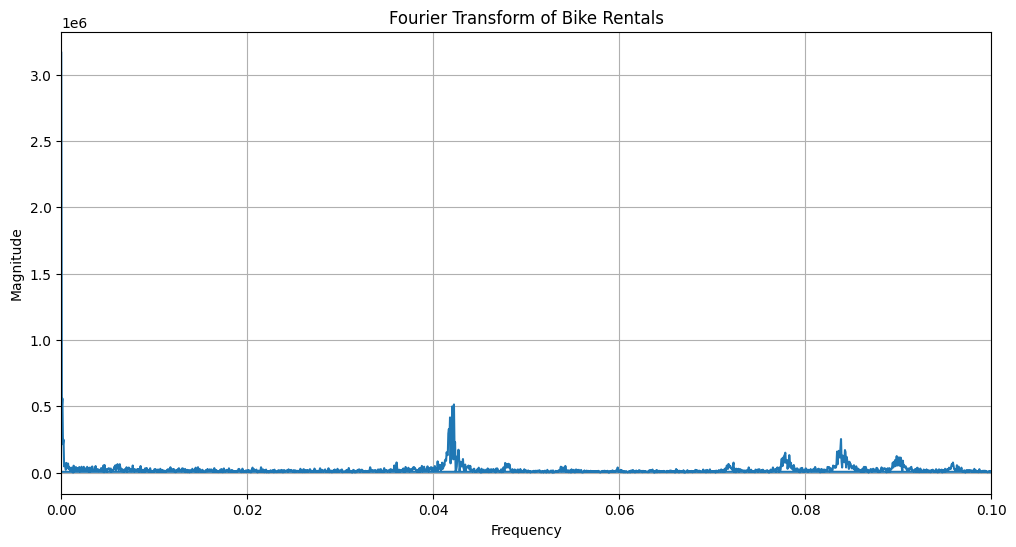

In [13]:
cnt_values = train_data_final['cnt'].values

fourier_transform = fft(cnt_values)

n = len(cnt_values)
frequencies = np.fft.fftfreq(n)

plt.figure(figsize=(12, 6))
plt.plot(frequencies, np.abs(fourier_transform))
plt.title('Fourier Transform of Bike Rentals')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.xlim(0, 0.1)
plt.grid()
plt.show()

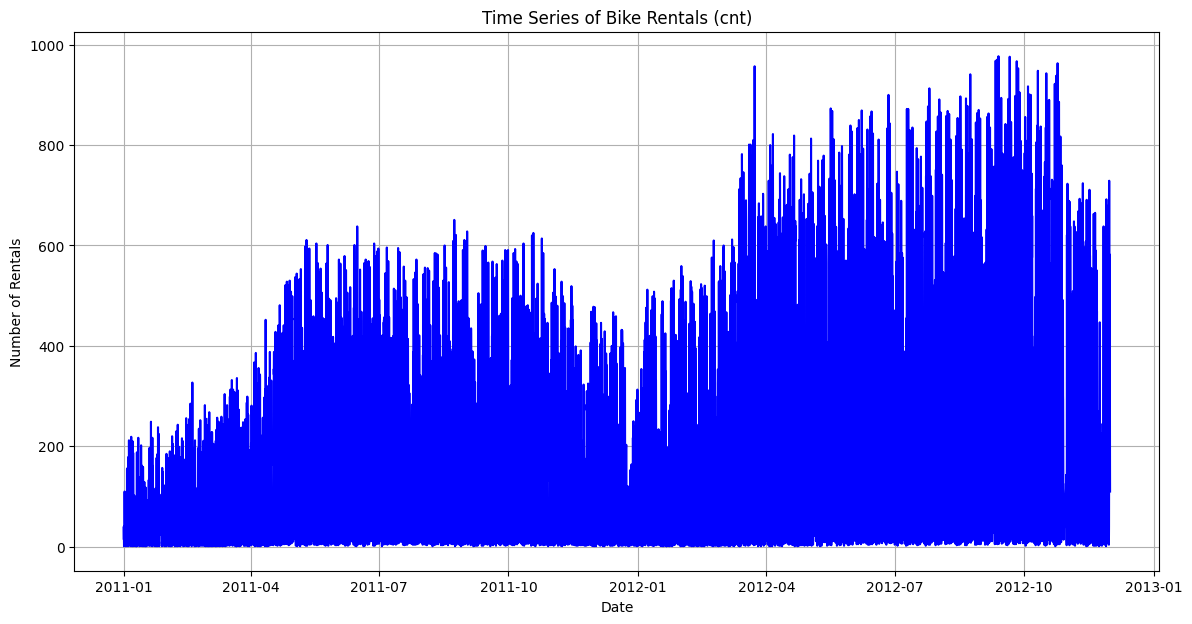

In [14]:
plt.figure(figsize=(14, 7))
plt.plot(train_data_final.index, train_data_final['cnt'], color='blue')
plt.title('Time Series of Bike Rentals (cnt)')
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.grid()
plt.show()

<Figure size 1200x600 with 0 Axes>

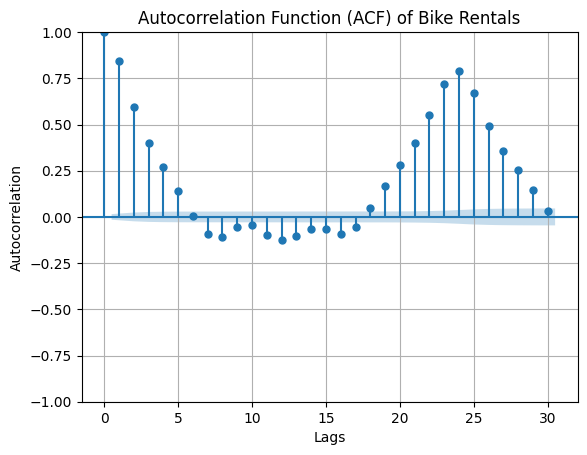

In [15]:
plt.figure(figsize=(12, 6))
plot_acf(train_data_final['cnt'], lags=30)
plt.title('Autocorrelation Function (ACF) of Bike Rentals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid()
plt.show()

In [37]:
train_data_final['lag_1'] = train_data_final['cnt'].shift(1)
train_data_final['lag_2'] = train_data_final['cnt'].shift(2)
train_data_final['rolling_mean_3'] = train_data_final['cnt'].rolling(window=3).mean()
train_data_final['rolling_mean_7'] = train_data_final['cnt'].rolling(window=7).mean()
train_data_final['rolling_std_3'] = train_data_final['cnt'].rolling(window=3).std()
train_data_final['rolling_std_7'] = train_data_final['cnt'].rolling(window=7).std()

train_data_final['is_weekend'] = train_data_final['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)
train_data_final['is_holiday'] = train_data_final['day_of_week'].apply(lambda x: 1 if x in [0, 1] else 0)
train_data_final['season'] = train_data_final['month'].apply(lambda x: 'winter' if x in [12, 1, 2] else 'spring' if x in [3, 4, 5] else 'summer' if x in [6, 7, 8] else 'autumn')
train_data_final['is_spring'] = train_data_final['season'].apply(lambda x: 1 if x == 'spring' else 0)
train_data_final['is_summer'] = train_data_final['season'].apply(lambda x: 1 if x == 'summer' else 0)
train_data_final['is_autumn'] = train_data_final['season'].apply(lambda x: 1 if x == 'autumn' else 0)
train_data_final['is_winter'] = train_data_final['season'].apply(lambda x: 1 if x == 'winter' else 0)

train_data_final['temp_atemp_diff'] = train_data_final['temp'] - train_data_final['atemp']
train_data_final['hum_windspeed_interaction'] = train_data_final['hum'] * train_data_final['windspeed']

train_data_final['sin_day_of_week'] = np.sin(2 * np.pi * train_data_final['day_of_week'] / 7)
train_data_final['cos_day_of_week'] = np.cos(2 * np.pi * train_data_final['day_of_week'] / 7)

train_data_final['is_month_end'] = train_data_final['day'] >= 25


train_data_final['temp_month_rel'] = train_data_final['temp'] / train_data_final.groupby('month')['temp'].transform('mean')
train_data_final['hum_month_rel'] = train_data_final['hum'] / train_data_final.groupby('month')['hum'].transform('mean')

train_data_final['is_heatwave'] = train_data_final['temp'] > 30
train_data_final['is_storm'] = train_data_final['windspeed'] > 40

train_data_final['windspeed_change'] = train_data_final['windspeed'] - train_data_final['windspeed'].shift(1)

train_data_final['temp_diff_from_max'] = train_data_final['temp'] - train_data_final.groupby('month')['temp'].transform('max')
train_data_final['temp_windspeed_interaction'] = train_data_final['temp'] * train_data_final['windspeed']

train_data_final['lagged_temp'] = train_data_final['temp'].shift(1)
train_data_final['lagged_hum'] = train_data_final['hum'].shift(1)
train_data_final['lagged_weathersit'] = train_data_final['weathersit'].shift(1)


display(train_data_final.head())
display(train_data_final.columns)
display(train_data_final.shape)

,temp,atemp,hum,windspeed,weathersit,cnt,year,month,day,day_of_week,...,temp_month_rel,hum_month_rel,is_heatwave,is_storm,windspeed_change,temp_diff_from_max,temp_windspeed_interaction,lagged_temp,lagged_hum,lagged_weathersit
date_hour,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0.24,0.2879,0.81,0.0,1,16,2011,1,1,5,...,1.009120,1.393759,False,False,NaN,-0.34,0.0,NaN,NaN,NaN
2011-01-01 01:00:00,0.22,0.2727,0.80,0.0,1,40,2011,1,1,5,...,0.925027,1.376553,False,False,0.0,-0.36,0.0,0.24,0.81,1.0
2011-01-01 02:00:00,0.22,0.2727,0.80,0.0,1,32,2011,1,1,5,...,0.925027,1.376553,False,False,0.0,-0.36,0.0,0.22,0.80,1.0
2011-01-01 03:00:00,0.24,0.2879,0.75,0.0,1,13,2011,1,1,5,...,1.009120,1.290518,False,False,0.0,-0.34,0.0,0.22,0.80,1.0
2011-01-01 04:00:00,0.24,0.2879,0.75,0.0,1,1,2011,1,1,5,...,1.009120,1.290518,False,False,0.0,-0.34,0.0,0.24,0.75,1.0


Index(['temp', 'atemp', 'hum', 'windspeed', 'weathersit', 'cnt', 'year',
       'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month',
       'lag_1', 'lag_2', 'rolling_mean_3', 'rolling_mean_7', 'rolling_std_3',
       'rolling_std_7', 'is_weekend', 'is_holiday', 'season', 'is_spring',
       'is_summer', 'is_autumn', 'is_winter', 'temp_atemp_diff',
       'hum_windspeed_interaction', 'sin_day_of_week', 'cos_day_of_week',
       'is_month_end', 'temp_month_rel', 'hum_month_rel', 'is_heatwave',
       'is_storm', 'windspeed_change', 'temp_diff_from_max',
       'temp_windspeed_interaction', 'lagged_temp', 'lagged_hum',
       'lagged_weathersit'],
      dtype='object')

(16531, 41)

In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import randint

# Define features and target
features = ['temp', 'atemp', 'hum', 'windspeed', 'weathersit', 'cnt', 'year',
       'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month',
       'lag_1', 'lag_2', 'rolling_mean_3', 'rolling_mean_7', 'rolling_std_3',
       'rolling_std_7', 'is_weekend', 'is_holiday', 'season', 'is_spring',
       'is_summer', 'is_autumn', 'is_winter', 'temp_atemp_diff',
       'hum_windspeed_interaction', 'sin_day_of_week', 'cos_day_of_week',
       'is_month_end', 'temp_month_rel', 'hum_month_rel', 'is_heatwave',
       'is_storm', 'windspeed_change', 'temp_diff_from_max',
       'temp_windspeed_interaction', 'lagged_temp', 'lagged_hum',
       'lagged_weathersit']

# Ensure data is clean and ready
X = train_data_final[features].dropna()
Y = train_data_final['cnt'][X.index]

# Check for non-numeric columns
non_numeric_cols = X.select_dtypes(include=['object', 'category']).columns
print("Non-numeric columns:", non_numeric_cols)

# One-hot encode non-numeric columns (if any)
if 'season' in non_numeric_cols:
    X = pd.get_dummies(X, columns=['season'], drop_first=True)

# Ensure all columns are numeric
assert X.select_dtypes(include=['object', 'category']).shape[1] == 0, "Non-numeric columns remain!"

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define parameter grid for Randomized Search
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

# Define scoring metric
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    scoring=scorer,
    verbose=1
)

# Fit the model
random_search.fit(X_train, Y_train)

# Get the best model and parameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Predict on the test set
Y_pred = best_model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(Y_test, Y_pred, squared=False)

# Print results
print(f"Best Parameters: {best_params}")
print(f"Best Score: {random_search.best_score_}")
print(f"RMSE: {rmse}")




Non-numeric columns: Index(['season'], dtype='object')
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10}
Best Score: -0.320790933829965
RMSE: 0.49796504989374524
